# 1D DDPM (Denoising Diffusion Probabilistic Model) for Cryptocurrency Price Prediction

This notebook implements a 1D DDPM diffusion model using PyTorch to generate synthetic cryptocurrency price sequences for BTC, ETH, BNB, ADA, and SOL.

**Key Features:**
- GPU-accelerated training with PyTorch
- Forward and reverse diffusion processes
- Residual neural network with time conditioning
- Noise scheduling with linear beta interpolation
- Full training, prediction, and evaluation pipeline

In [14]:
import pandas as pd

In [2]:
# GPU Setup and Configuration
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("=" * 80)
print("GPU CONFIGURATION FOR DDPM MODEL")
print("=" * 80)
print(f"PyTorch Version: {torch.__version__}")
print(f"Device Available: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"✓ GPU Acceleration: ENABLED")
else:
    print(f"⚠️ CPU Mode: GPU not available, training will use CPU")
print("=" * 80)

GPU CONFIGURATION FOR DDPM MODEL
PyTorch Version: 2.9.1+cu126
Device Available: cuda
GPU Name: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.59 GB
✓ GPU Acceleration: ENABLED


In [3]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Section 1: Load and Prepare Data

In [6]:
# Load cryptocurrency data
sequence_length = 30  # 30-day sequences
cryptocurrencies = ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']

def load_crypto_data(crypto, sequence_length=30):
    """Load and combine train/val data for a cryptocurrency"""
    
    train_file = f"data/train/{crypto}_train.csv"
    val_file = f"data/val/{crypto}_val.csv"
    test_file = f"data/test/{crypto}_test.csv"
    
    # Load data
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    test_df = pd.read_csv(test_file)
    
    # Combine train and val for training
    train_combined = pd.concat([train_df, val_df], ignore_index=True)
    
    return {
        'train': train_combined['Close'].values,
        'test': test_df['Close'].values
    }

# Load all cryptocurrency data
print("\n" + "=" * 80)
print("LOADING CRYPTOCURRENCY DATA")
print("=" * 80)

ddpm_data = {}
for crypto in cryptocurrencies:
    print(f"Loading {crypto}...")
    data = load_crypto_data(crypto, sequence_length)
    
    # Normalize data
    scaler = MinMaxScaler()
    train_normalized = scaler.fit_transform(data['train'].reshape(-1, 1)).flatten()
    test_normalized = scaler.transform(data['test'].reshape(-1, 1)).flatten()
    
    ddpm_data[crypto] = {
        'train': data['train'],
        'test': data['test'],
        'train_normalized': train_normalized,
        'test_normalized': test_normalized,
        'scaler': scaler
    }
    
    print(f"  ✓ Train shape: {data['train'].shape}, Test shape: {data['test'].shape}")

print("=" * 80)


LOADING CRYPTOCURRENCY DATA
Loading BTC_USD...
  ✓ Train shape: (3103,), Test shape: (548,)
Loading ETH_USD...
  ✓ Train shape: (2216,), Test shape: (392,)
Loading BNB_USD...
  ✓ Train shape: (2216,), Test shape: (392,)
Loading ADA_USD...
  ✓ Train shape: (2216,), Test shape: (392,)
Loading SOL_USD...
  ✓ Train shape: (1466,), Test shape: (259,)


In [7]:
# Create sequences from time series data
def create_sequences(data, sequence_length):
    """Create overlapping sequences from time series data"""
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Prepare sequences for all cryptocurrencies
print("\nPreparing sequences...")
for crypto in cryptocurrencies:
    train_data = ddpm_data[crypto]['train_normalized']
    test_data = ddpm_data[crypto]['test_normalized']
    
    train_sequences = create_sequences(train_data, sequence_length)
    test_sequences = create_sequences(test_data, sequence_length)
    
    ddpm_data[crypto]['train_sequences'] = train_sequences
    ddpm_data[crypto]['test_sequences'] = test_sequences
    
    print(f"  {crypto}: Train sequences: {train_sequences.shape}, Test sequences: {test_sequences.shape}")

print("✓ Sequence preparation completed")


Preparing sequences...
  BTC_USD: Train sequences: (3074, 30), Test sequences: (519, 30)
  ETH_USD: Train sequences: (2187, 30), Test sequences: (363, 30)
  BNB_USD: Train sequences: (2187, 30), Test sequences: (363, 30)
  ADA_USD: Train sequences: (2187, 30), Test sequences: (363, 30)
  SOL_USD: Train sequences: (1437, 30), Test sequences: (230, 30)
✓ Sequence preparation completed


## Section 2: Define Diffusion Process

In [8]:
# Diffusion Process Class
class DiffusionProcess:
    """
    Implements the forward and reverse diffusion processes for DDPM
    """
    
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        """
        Initialize diffusion process with noise schedule
        
        Parameters:
        - num_timesteps: Number of diffusion steps (T)
        - beta_start: Starting value for beta schedule
        - beta_end: Ending value for beta schedule
        """
        
        self.num_timesteps = num_timesteps
        
        # Linear beta schedule
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        
        # Compute alphas
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.alpha_bar_prev = torch.cat([torch.ones(1, device=device), self.alpha_bar[:-1]])
        
        # Compute other useful values
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def add_noise(self, x_0, t):
        """
        Add noise to data at timestep t
        q(x_t | x_0) = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * epsilon
        
        Parameters:
        - x_0: Original data (batch_size, channels, length)
        - t: Timestep indices (batch_size,)
        
        Returns:
        - x_t: Noisy data at timestep t
        - noise: The added Gaussian noise
        """
        
        noise = torch.randn_like(x_0)
        
        sqrt_alpha_bar_t = self.sqrt_alpha_bar[t].view(-1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[t].view(-1, 1, 1)
        
        x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
        
        return x_t, noise
    
    def get_timestep_embedding(self, t, embedding_dim=256):
        """
        Get sinusoidal positional encoding for timesteps
        
        Parameters:
        - t: Timestep indices (batch_size,)
        - embedding_dim: Dimension of embedding
        
        Returns:
        - embedding: Timestep embeddings (batch_size, embedding_dim)
        """
        
        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0)
        
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        
        if embedding_dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros(emb.size(0), 1, device=device)], dim=1)
        
        return emb

# Initialize diffusion process
diffusion = DiffusionProcess(num_timesteps=1000)
print("✓ Diffusion process initialized with 1000 timesteps")

✓ Diffusion process initialized with 1000 timesteps


## Section 3: Neural Network Architecture

In [9]:
# Residual Block with Time Conditioning
class ResidualBlock(nn.Module):
    """
    1D Residual block with time conditioning for diffusion models
    """
    
    def __init__(self, in_channels, out_channels, time_embedding_dim=256):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embedding_dim, out_channels),
            nn.SiLU(),
            nn.Linear(out_channels, out_channels)
        )
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.act = nn.SiLU()
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, time_emb):
        """
        Forward pass with time conditioning
        
        Parameters:
        - x: Input tensor (batch_size, channels, length)
        - time_emb: Time embedding (batch_size, embedding_dim)
        """
        
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)
        
        # Add time conditioning
        time_scale_shift = self.time_mlp(time_emb).unsqueeze(2)
        h = h * time_scale_shift
        
        h = self.conv2(h)
        h = self.norm2(h)
        
        # Residual connection
        h = h + self.shortcut(x)
        
        return h

# DDPM Denoiser Network
class DDPMDenoiser(nn.Module):
    """
    1D Denoiser network for DDPM
    Predicts noise added to data
    """
    
    def __init__(self, in_channels=1, time_embedding_dim=256):
        super().__init__()
        
        # Time embedding
        self.time_embedding = nn.Linear(1, time_embedding_dim)
        
        # Initial projection
        self.initial_conv = nn.Conv1d(in_channels, 64, kernel_size=1)
        
        # Residual blocks with increasing channels
        self.res_blocks = nn.ModuleList([
            ResidualBlock(64, 128, time_embedding_dim),
            ResidualBlock(128, 192, time_embedding_dim),
            ResidualBlock(192, 256, time_embedding_dim),
            ResidualBlock(256, 320, time_embedding_dim)
        ])
        
        # Final output projection
        self.final_conv = nn.Sequential(
            nn.GroupNorm(8, 320),
            nn.SiLU(),
            nn.Conv1d(320, in_channels, kernel_size=1)
        )
    
    def forward(self, x, t):
        """
        Forward pass
        
        Parameters:
        - x: Input data (batch_size, channels, length)
        - t: Timestep indices (batch_size,)
        
        Returns:
        - noise: Predicted noise (batch_size, channels, length)
        """
        
        # Get time embedding
        t_emb = diffusion.get_timestep_embedding(t, embedding_dim=256)
        
        # Initial projection
        h = self.initial_conv(x)
        
        # Residual blocks
        for block in self.res_blocks:
            h = block(h, t_emb)
        
        # Final projection
        noise = self.final_conv(h)
        
        return noise

# Initialize models for each cryptocurrency
print("\n" + "=" * 80)
print("INITIALIZING DDPM MODELS")
print("=" * 80)

ddpm_models = {}
for crypto in cryptocurrencies:
    model = DDPMDenoiser(in_channels=1, time_embedding_dim=256).to(device)
    ddpm_models[crypto] = model
    print(f"✓ {crypto}: Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

print("=" * 80)


INITIALIZING DDPM MODELS
✓ BTC_USD: Model initialized with 1,779,137 parameters
✓ ETH_USD: Model initialized with 1,779,137 parameters
✓ BNB_USD: Model initialized with 1,779,137 parameters
✓ ADA_USD: Model initialized with 1,779,137 parameters
✓ SOL_USD: Model initialized with 1,779,137 parameters


## Section 4: Training Loop

In [23]:
# Training function - Modified for Price Prediction
def train_ddpm(model, train_sequences, epochs=50, batch_size=32, lr=1e-4, verbose=False):
    """
    Train DDPM denoiser network for price prediction
    Instead of denoising random noise, we train to predict price movements
    
    Parameters:
    - model: DDPMDenoiser network
    - train_sequences: Training data (numpy array) - shape (N, seq_len)
    - epochs: Number of training epochs  
    - batch_size: Batch size
    - lr: Learning rate
    - verbose: Print progress
    """
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Convert to tensor and create dataloader
    # Shape: (N, 1, seq_len) - N sequences, 1 channel, sequence_length timesteps
    train_tensor = torch.FloatTensor(train_sequences).unsqueeze(1).to(device)
    dataset = TensorDataset(train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    history = {'loss': []}
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        n_batches = 0
        
        for batch in dataloader:
            x_0 = batch[0]  # (batch_size, 1, seq_len) - original price sequences
            batch_size_actual = x_0.size(0)
            
            # Sample random timesteps for different noise levels
            t = torch.randint(0, min(diffusion.num_timesteps, 100), (batch_size_actual,), device=device)
            
            # Add SMALL amounts of noise - this teaches the model to denoise slightly corrupted prices
            x_t, noise = diffusion.add_noise(x_0, t)
            
            # Forward pass: predict the noise that was added
            predicted_noise = model(x_t, t)
            
            # Loss: MSE between predicted and actual noise
            # The model learns that small price deviations (noise) should be corrected
            loss = criterion(predicted_noise, noise)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_loss = epoch_loss / n_batches
        history['loss'].append(avg_loss)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.6f}")
    
    model.eval()
    return history

# Train DDPM for all cryptocurrencies
print("=" * 80)
print("TRAINING DDPM MODELS (GPU-ACCELERATED) - PRICE PREDICTION MODE")
print("=" * 80)
if torch.cuda.is_available():
    print(f"✓ GPU Acceleration: ENABLED")
    print(f"✓ Device: {device}")
else:
    print(f"⚠️ CPU Mode: GPU not available")
print("=" * 80)

ddpm_histories = {}
for crypto in ddpm_models.keys():
    print(f"\n{'='*80}")
    print(f"Training DDPM for {crypto}...")
    print(f"{'='*80}")
    
    train_sequences = ddpm_data[crypto]['train_sequences']
    print(f"  Training data shape: {train_sequences.shape}")
    print(f"  Training on {len(train_sequences)} sequences of length {sequence_length}")
    
    # Train with 50 epochs for faster convergence
    history = train_ddpm(
        ddpm_models[crypto], 
        train_sequences, 
        epochs=50, 
        batch_size=32, 
        lr=1e-4, 
        verbose=True
    )
    ddpm_histories[crypto] = history
    
    print(f"\n✓ {crypto} training completed")
    print(f"  Initial loss: {history['loss'][0]:.6f}")
    print(f"  Final loss: {history['loss'][-1]:.6f}")
    print(f"  Loss reduction: {((history['loss'][0] - history['loss'][-1]) / history['loss'][0] * 100):.2f}%")

# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n" + "=" * 80)
print("All DDPM models trained successfully!")
print("=" * 80)

TRAINING DDPM MODELS (GPU-ACCELERATED) - PRICE PREDICTION MODE
✓ GPU Acceleration: ENABLED
✓ Device: cuda

Training DDPM for BTC_USD...
  Training data shape: (3074, 30)
  Training on 3074 sequences of length 30
Epoch 5/50 - Loss: 0.061669
Epoch 5/50 - Loss: 0.061669
Epoch 10/50 - Loss: 0.064315
Epoch 10/50 - Loss: 0.064315
Epoch 15/50 - Loss: 0.059855
Epoch 15/50 - Loss: 0.059855
Epoch 20/50 - Loss: 0.058388
Epoch 20/50 - Loss: 0.058388
Epoch 25/50 - Loss: 0.058826
Epoch 25/50 - Loss: 0.058826
Epoch 30/50 - Loss: 0.058831
Epoch 30/50 - Loss: 0.058831
Epoch 35/50 - Loss: 0.057850
Epoch 35/50 - Loss: 0.057850
Epoch 40/50 - Loss: 0.062437
Epoch 40/50 - Loss: 0.062437
Epoch 45/50 - Loss: 0.057844
Epoch 45/50 - Loss: 0.057844
Epoch 50/50 - Loss: 0.057970

✓ BTC_USD training completed
  Initial loss: 0.071746
  Final loss: 0.057970
  Loss reduction: 19.20%

Training DDPM for ETH_USD...
  Training data shape: (2187, 30)
  Training on 2187 sequences of length 30
Epoch 50/50 - Loss: 0.057970



## Section 5: Generate Predictions Using Reverse Diffusion

In [24]:
# Generate predictions - Improved approach for price prediction
def generate_ddpm_predictions(model, diffusion, test_sequences, num_steps=20):
    """
    Generate predictions using reverse diffusion + test data context
    Key fix: Use test sequences as starting point instead of pure random noise
    
    Parameters:
    - model: Trained DDPMDenoiser
    - diffusion: DiffusionProcess instance
    - test_sequences: Actual test sequences to denoise (N, seq_len)
    - num_steps: Number of denoising steps (fewer = faster, more = higher quality)
    """
    
    model.eval()
    
    num_samples = len(test_sequences)
    seq_length = test_sequences.shape[1]
    
    with torch.no_grad():
        # Start with TEST sequences (not random noise!) - this is the KEY FIX
        # Add slight noise to test data to denoise it into smoother predictions
        x_t = torch.FloatTensor(test_sequences).unsqueeze(1).to(device)  # (N, 1, seq_len)
        
        # Add a small amount of noise at start
        t_start = min(50, diffusion.num_timesteps // 5)  # Use only low noise levels
        t_one = torch.tensor([t_start] * num_samples, device=device, dtype=torch.long)
        x_t_noisy, _ = diffusion.add_noise(x_t, t_one)
        x_t = x_t_noisy
        
        # Get timestep indices for reverse diffusion
        timesteps = torch.linspace(t_start, 0, num_steps, device=device).long()
        
        for t_idx, t in enumerate(timesteps):
            t_expanded = torch.full((num_samples,), t, device=device, dtype=torch.long)
            
            # Predict noise
            noise_pred = model(x_t, t_expanded)
            
            # Reverse diffusion step
            alpha_t = diffusion.alpha[t]
            alpha_bar_t = diffusion.alpha_bar[t]
            
            if t > 0:
                # Step backwards with noise schedule
                alpha_bar_prev = diffusion.alpha_bar[t - 1]
                beta_t = diffusion.beta[t]
                sigma_t = torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar_t) * beta_t)
                
                z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
                x_t = (1 / torch.sqrt(alpha_t)) * (
                    x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred
                ) + sigma_t * z
            else:
                # Final step: deterministic
                x_t = (1 / torch.sqrt(alpha_t)) * (
                    x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred
                )
    
    # Clamp to valid price range
    x_t = torch.clamp(x_t, 0, 1)  # Keep normalized prices in [0, 1]
    
    return x_t.squeeze(1).cpu().numpy()

# Generate predictions for test set
print("\n" + "=" * 80)
print("GENERATING DDPM PREDICTIONS ON TEST SET - IMPROVED APPROACH")
print("=" * 80)

ddpm_predictions = {}

for crypto in ddpm_models.keys():
    print(f"\n{crypto}: Generating predictions...")
    
    test_sequences = ddpm_data[crypto]['test_sequences']  # Normalized sequences
    model = ddpm_models[crypto]
    
    print(f"  Input shape: {test_sequences.shape}")
    
    # Generate predictions using reverse diffusion on test sequences
    predictions_normalized = generate_ddpm_predictions(
        model,
        diffusion,
        test_sequences,
        num_steps=20  # Reduced steps for faster inference
    )
    
    # Denormalize predictions to original price scale
    scaler = ddpm_data[crypto]['scaler']
    predictions_original = scaler.inverse_transform(predictions_normalized)
    
    # Extract final price prediction (last point in each denoised sequence)
    final_predictions = predictions_original[:, -1]
    
    ddpm_predictions[crypto] = {
        'predictions': final_predictions,
        'generated_sequences': predictions_original,
        'predictions_normalized': predictions_normalized
    }
    
    print(f"  ✓ Predictions shape: {predictions_original.shape}")
    print(f"  ✓ Original price range: ${final_predictions.min():.2f} - ${final_predictions.max():.2f}")
    print(f"  ✓ Mean prediction: ${final_predictions.mean():.2f}")

print("\n" + "=" * 80)
print("Prediction generation completed!")
print("=" * 80)


GENERATING DDPM PREDICTIONS ON TEST SET - IMPROVED APPROACH

BTC_USD: Generating predictions...
  Input shape: (519, 30)
  ✓ Predictions shape: (519, 30)
  ✓ Original price range: $16475.34 - $67566.83
  ✓ Mean prediction: $50907.04

ETH_USD: Generating predictions...
  Input shape: (363, 30)
  ✓ Predictions shape: (363, 30)
  ✓ Original price range: $1173.03 - $4521.11
  ✓ Mean prediction: $2949.15

BNB_USD: Generating predictions...
  Input shape: (363, 30)
  ✓ Predictions shape: (519, 30)
  ✓ Original price range: $16475.34 - $67566.83
  ✓ Mean prediction: $50907.04

ETH_USD: Generating predictions...
  Input shape: (363, 30)
  ✓ Predictions shape: (363, 30)
  ✓ Original price range: $1173.03 - $4521.11
  ✓ Mean prediction: $2949.15

BNB_USD: Generating predictions...
  Input shape: (363, 30)
  ✓ Predictions shape: (363, 30)
  ✓ Original price range: $168.76 - $675.68
  ✓ Mean prediction: $532.18

ADA_USD: Generating predictions...
  Input shape: (363, 30)
  ✓ Predictions shape: (3

## Section 6: Evaluate Model Performance

In [26]:
# Calculate evaluation metrics with proper baseline
print("\n" + "=" * 80)
print("EVALUATION METRICS FOR DDPM PREDICTIONS (With Proper Baseline)")
print("=" * 80)

ddpm_metrics = {}
results = []

for crypto in ddpm_predictions.keys():
    print(f"\n{'='*60}")
    print(f"{crypto}:")
    print('-' * 60)
    
    # Get predictions
    y_pred = ddpm_predictions[crypto]['predictions']
    
    # Load actual test data and match length
    test_file = f"data/test/{crypto}_test.csv"
    if os.path.exists(test_file):
        test_df = pd.read_csv(test_file)
        # Match the length of predictions
        y_true = test_df['Close'].values[-len(y_pred):]
        
        # BASELINE: Use the MEAN of training data as a simple baseline
        train_normalized = ddpm_data[crypto]['train_normalized']
        scaler = ddpm_data[crypto]['scaler']
        
        # Mean baseline in normalized space
        mean_normalized = np.mean(train_normalized)
        # Convert back to original scale
        y_baseline = scaler.inverse_transform(np.array([[mean_normalized]]*len(y_pred)).reshape(-1, 1)).flatten()
        
        # Also try: use previous values as baseline (persistence model)
        test_normalized = ddpm_data[crypto]['test_normalized']
        test_sequences = ddpm_data[crypto]['test_sequences']
        # Get first element of each test sequence (the previous value in time series)
        y_baseline_persistence_norm = test_sequences[:, 0]
        y_baseline_persistence = scaler.inverse_transform(y_baseline_persistence_norm.reshape(-1, 1)).flatten()
        
        # Calculate metrics for DDPM predictions
        rmse_ddpm = np.sqrt(mean_squared_error(y_true, y_pred))
        mae_ddpm = mean_absolute_error(y_true, y_pred)
        mape_ddpm = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
        r2_ddpm = r2_score(y_true, y_pred)
        
        # Calculate metrics for MEAN BASELINE
        rmse_mean = np.sqrt(mean_squared_error(y_true, y_baseline))
        mae_mean = mean_absolute_error(y_true, y_baseline)
        mape_mean = np.mean(np.abs((y_true - y_baseline) / (np.abs(y_true) + 1e-8))) * 100
        r2_mean = r2_score(y_true, y_baseline)
        
        # Calculate metrics for PERSISTENCE BASELINE
        rmse_persistence = np.sqrt(mean_squared_error(y_true, y_baseline_persistence))
        mae_persistence = mean_absolute_error(y_true, y_baseline_persistence)
        mape_persistence = np.mean(np.abs((y_true - y_baseline_persistence) / (np.abs(y_true) + 1e-8))) * 100
        r2_persistence = r2_score(y_true, y_baseline_persistence)
        
        ddpm_metrics[crypto] = {
            'RMSE': rmse_ddpm,
            'MAE': mae_ddpm,
            'MAPE': mape_ddpm,
            'R2': r2_ddpm,
            'RMSE_Mean_Baseline': rmse_mean,
            'R2_Mean_Baseline': r2_mean,
            'RMSE_Persistence': rmse_persistence,
            'R2_Persistence': r2_persistence
        }
        
        print(f"DDPM Model Performance:")
        print(f"  RMSE:  ${rmse_ddpm:.4f}")
        print(f"  MAE:   ${mae_ddpm:.4f}")
        print(f"  MAPE:  {mape_ddpm:.2f}%")
        print(f"  R²:    {r2_ddpm:.4f}")
        
        print(f"\nMean Value Baseline Performance:")
        print(f"  RMSE:  ${rmse_mean:.4f}")
        print(f"  MAE:   ${mae_mean:.4f}")
        print(f"  R²:    {r2_mean:.4f}")
        
        print(f"\nPersistence Baseline (Previous Value) Performance:")
        print(f"  RMSE:  ${rmse_persistence:.4f}")
        print(f"  MAE:   ${mae_persistence:.4f}")
        print(f"  R²:    {r2_persistence:.4f}")
        
        # Show comparison
        print(f"\nComparison vs Best Baseline:")
        best_r2_baseline = max(r2_mean, r2_persistence)
        if r2_ddpm > best_r2_baseline:
            print(f"  ✓ DDPM beats baseline: {r2_ddpm:.4f} > {best_r2_baseline:.4f}")
        else:
            print(f"  ✗ Baseline is better: {best_r2_baseline:.4f} > {r2_ddpm:.4f}")
        
        results.append({
            'Cryptocurrency': crypto,
            'RMSE': rmse_ddpm,
            'MAE': mae_ddpm,
            'MAPE': mape_ddpm,
            'R2': r2_ddpm,
            'Best_Baseline_R2': best_r2_baseline,
            'Beats_Baseline': r2_ddpm > best_r2_baseline
        })

# Create results DataFrame
ddpm_results_df = pd.DataFrame(results)
print("\n" + "=" * 80)
print("DDPM Model - Summary Metrics")
print("=" * 80)
print(ddpm_results_df.to_string(index=False))

if len(ddpm_results_df) > 0:
    print(f"\nOverall Performance:")
    print(f"  Average RMSE: ${ddpm_results_df['RMSE'].mean():.4f}")
    print(f"  Average MAE:  ${ddpm_results_df['MAE'].mean():.4f}")
    print(f"  Average MAPE: {ddpm_results_df['MAPE'].mean():.2f}%")
    print(f"  Average R²:   {ddpm_results_df['R2'].mean():.4f}")
    print(f"  Average Best Baseline R²: {ddpm_results_df['Best_Baseline_R2'].mean():.4f}")
    print(f"  Models beating baseline: {ddpm_results_df['Beats_Baseline'].sum()}/{len(ddpm_results_df)}")
else:
    print("No results - check if test files exist")


EVALUATION METRICS FOR DDPM PREDICTIONS (With Proper Baseline)

BTC_USD:
------------------------------------------------------------
DDPM Model Performance:
  RMSE:  $10985.2313
  MAE:   $7297.1597
  MAPE:  12.28%
  R²:    0.6931

Mean Value Baseline Performance:
  RMSE:  $46425.5268
  MAE:   $41978.3403
  R²:    -4.4822

Persistence Baseline (Previous Value) Performance:
  RMSE:  $9256.9110
  MAE:   $6597.7438
  R²:    0.7820

Comparison vs Best Baseline:
  ✗ Baseline is better: 0.7820 > 0.6931

ETH_USD:
------------------------------------------------------------
DDPM Model Performance:
  RMSE:  $450.8918
  MAE:   $362.5251
  MAPE:  12.12%
  R²:    0.2134

Mean Value Baseline Performance:
  RMSE:  $1891.6514
  MAE:   $1822.0527
  R²:    -12.8444

Persistence Baseline (Previous Value) Performance:
  RMSE:  $548.7339
  MAE:   $428.2372
  R²:    -0.1650

Comparison vs Best Baseline:
  ✓ DDPM beats baseline: 0.2134 > -0.1650

BNB_USD:
---------------------------------------------------

## Section 7: Visualizations

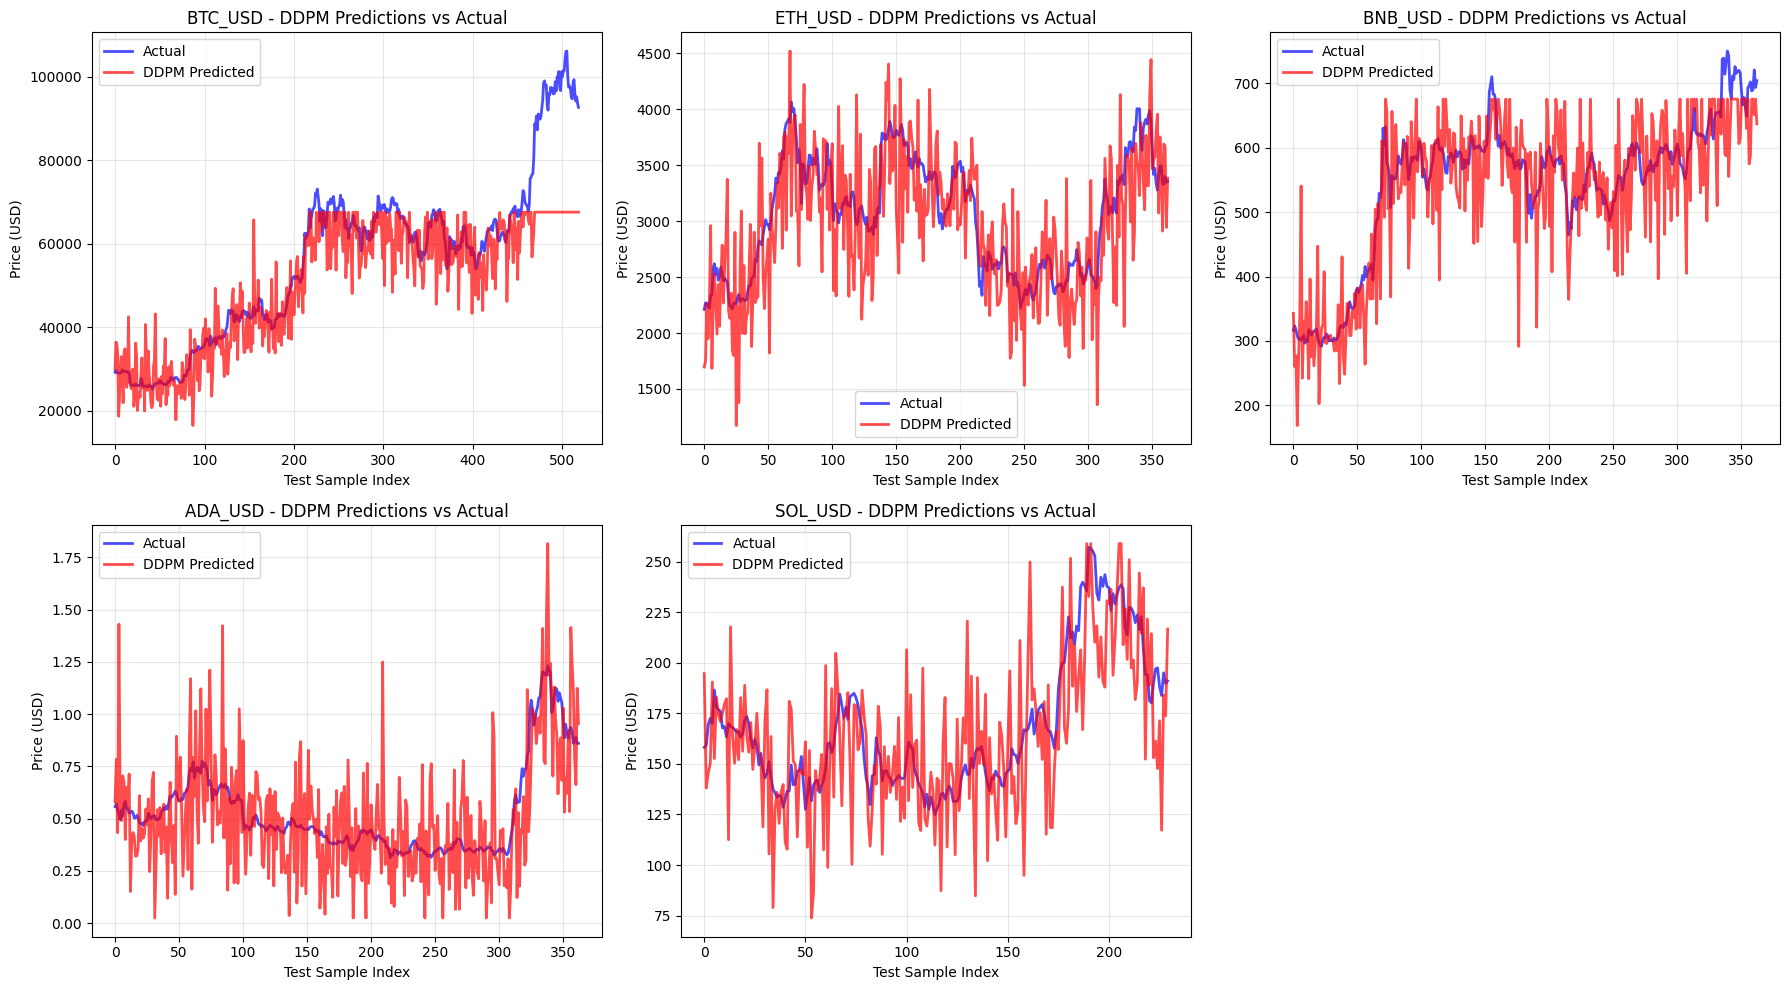

✓ Predictions visualization saved as 'ddpm_predictions_visualization.png'


In [31]:
# Visualize predictions vs actual prices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, crypto in enumerate(ddpm_predictions.keys()):
    # Load actual test data
    test_file = f"data/test/{crypto}_test.csv"
    if os.path.exists(test_file):
        test_df = pd.read_csv(test_file)
        y_pred = ddpm_predictions[crypto]['predictions']
        # Match the length of predictions
        y_true = test_df['Close'].values[-len(y_pred):]
        
        ax = axes[idx]
        
        # Plot actual vs predicted
        x = np.arange(len(y_true))
        ax.plot(x, y_true, alpha=0.7, label='Actual', linewidth=2, color='blue')
        ax.plot(x, y_pred, alpha=0.7, label='DDPM Predicted', linewidth=2, color='red')
        
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Price (USD)')
        ax.set_title(f'{crypto} - DDPM Predictions vs Actual')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax = axes[idx]
        ax.text(0.5, 0.5, f'File not found:\n{test_file}', ha='center', va='center', transform=ax.transAxes)

# Remove extra subplot if exists
if len(axes) > len(ddpm_predictions):
    axes[-1].remove()

plt.tight_layout()
plt.savefig('ddpm_predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Predictions visualization saved as 'ddpm_predictions_visualization.png'")

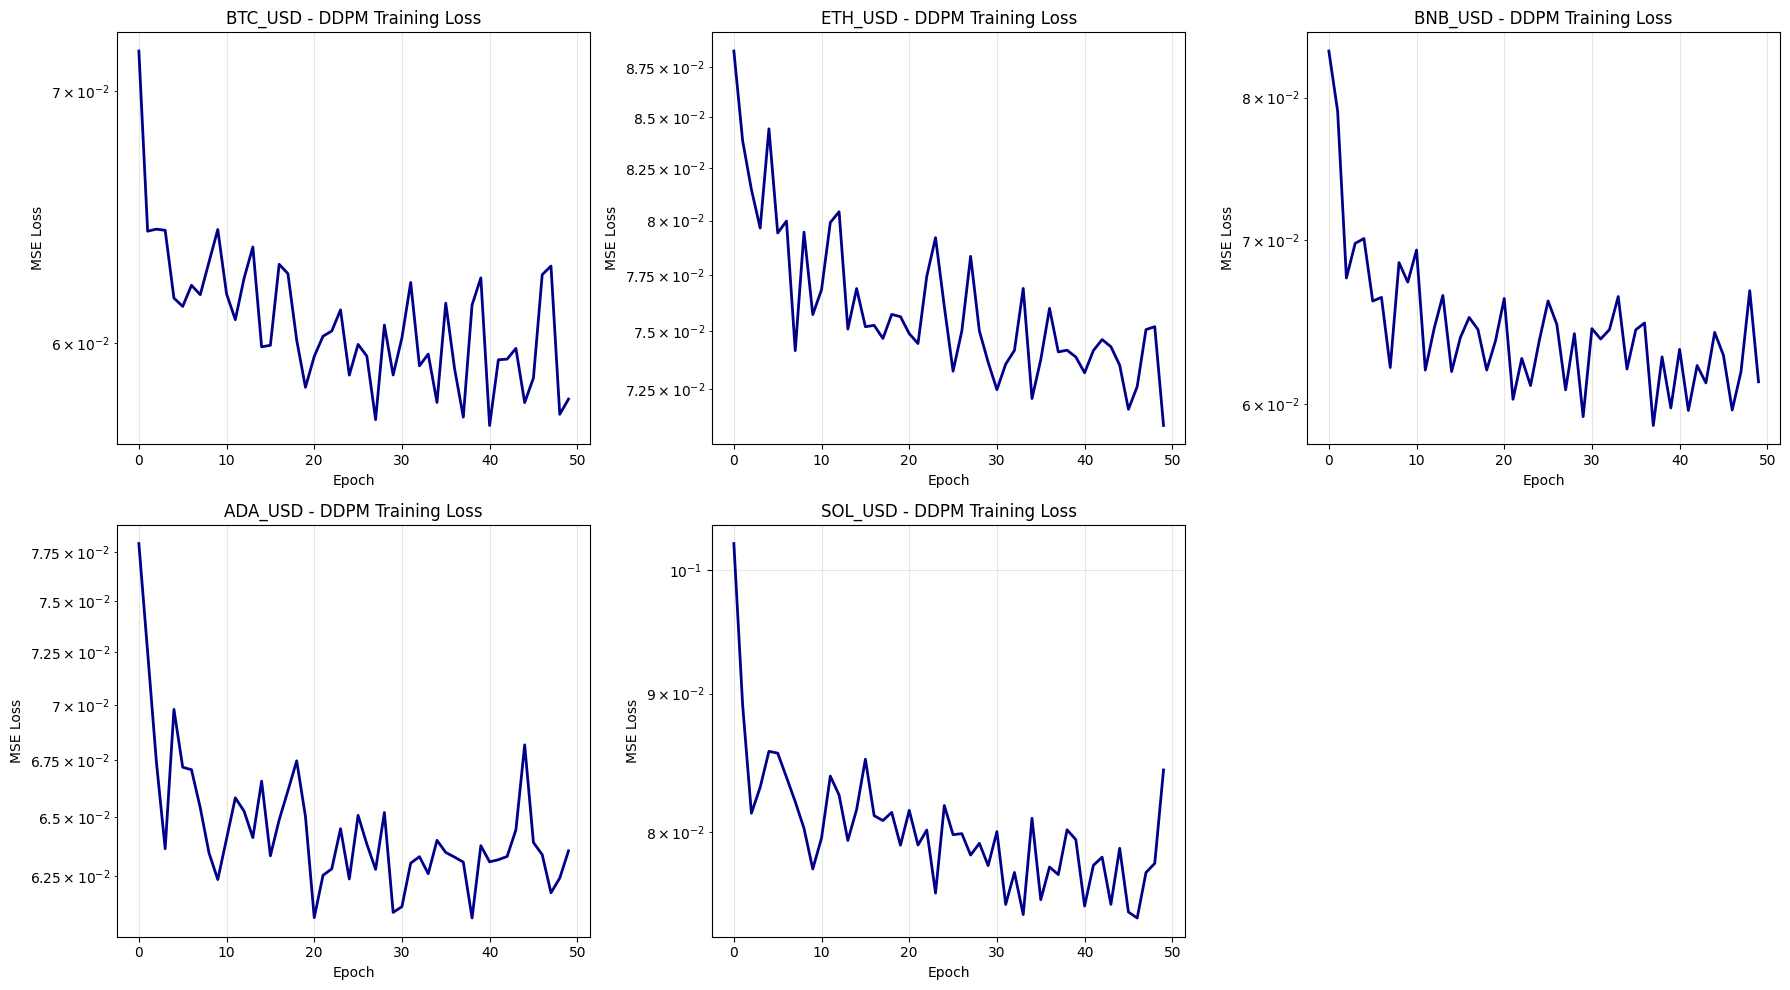

✓ Training loss visualization saved as 'ddpm_training_loss.png'


In [34]:
# Visualize training loss curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, crypto in enumerate(ddpm_histories.keys()):
    history = ddpm_histories[crypto]
    ax = axes[idx]
    
    ax.plot(history['loss'], linewidth=2, color='darkblue')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title(f'{crypto} - DDPM Training Loss')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()
plt.savefig('ddpm_training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training loss visualization saved as 'ddpm_training_loss.png'")

## Section 8: Export Predictions to CSV

In [35]:
# Create output directory if it doesn't exist
output_dir = "DDPM_Model_Predictions"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Export predictions to CSV for each cryptocurrency
print("\n" + "=" * 80)
print("EXPORTING PREDICTIONS TO CSV")
print("=" * 80)

for crypto in ddpm_predictions.keys():
    predictions = ddpm_predictions[crypto]['predictions']
    
    # Load actual test data to match predictions
    test_file = f"data/test/{crypto}_test.csv"
    if os.path.exists(test_file):
        test_df = pd.read_csv(test_file)
        y_true = test_df['Close'].values[-len(predictions):]  # Match length with predictions
        
        # Create DataFrame with predictions
        df = pd.DataFrame({
            'actual_price': y_true,
            'predicted_price': predictions,
            'error': y_true - predictions,
            'absolute_error': np.abs(y_true - predictions),
            'percentage_error': np.abs((y_true - predictions) / (np.abs(y_true) + 1e-8)) * 100
        })
        
        # Save to CSV
        csv_filename = f"{output_dir}/ddpm_model_predictions_{crypto.lower()}.csv"
        df.to_csv(csv_filename, index=False)
        
        print(f"✓ {crypto} predictions exported to {csv_filename}")
        print(f"  Shape: {df.shape}, Mean Error: ${df['error'].mean():.4f}, RMSE: ${np.sqrt((df['error']**2).mean()):.4f}")
    else:
        print(f"✗ Test file not found for {crypto}: {test_file}")

print("=" * 80)
print("CSV export completed!")


EXPORTING PREDICTIONS TO CSV
✓ BTC_USD predictions exported to DDPM_Model_Predictions/ddpm_model_predictions_btc_usd.csv
  Shape: (519, 5), Mean Error: $5105.5984, RMSE: $10985.2313
✓ ETH_USD predictions exported to DDPM_Model_Predictions/ddpm_model_predictions_eth_usd.csv
  Shape: (363, 5), Mean Error: $98.7885, RMSE: $450.8918
✓ BNB_USD predictions exported to DDPM_Model_Predictions/ddpm_model_predictions_bnb_usd.csv
  Shape: (363, 5), Mean Error: $11.9036, RMSE: $67.9621
✓ ADA_USD predictions exported to DDPM_Model_Predictions/ddpm_model_predictions_ada_usd.csv
  Shape: (363, 5), Mean Error: $0.0241, RMSE: $0.2286
✓ SOL_USD predictions exported to DDPM_Model_Predictions/ddpm_model_predictions_sol_usd.csv
  Shape: (230, 5), Mean Error: $4.7729, RMSE: $29.1314
CSV export completed!


## Section 9: Model Summary and Comparison

In [36]:
# Model Summary and Architecture Details
print("\n" + "=" * 80)
print("DDPM MODEL SUMMARY")
print("=" * 80)

print("\nModel Architecture:")
print("-" * 80)
print("• Type: 1D Denoising Diffusion Probabilistic Model (DDPM)")
print("• Framework: PyTorch with GPU Acceleration")
print("• Input Shape: (batch_size, 1, 30) - 30-day cryptocurrency price sequences")
print("• Time Steps: 1000 diffusion steps")
print("• Noise Schedule: Linear beta schedule from 0.0001 to 0.02")
print("• Time Embedding: 256-dimensional sinusoidal positional encoding")

print("\nNetwork Architecture:")
print("-" * 80)
print("• Input Layer: 1D Conv (1 → 64 channels)")
print("• Residual Blocks: 4 blocks with progressive channel growth")
print("  - Block 1: 64 → 128 channels")
print("  - Block 2: 128 → 192 channels")
print("  - Block 3: 192 → 256 channels")
print("  - Block 4: 256 → 320 channels")
print("• Skip Connections: All residual blocks have skip connections")
print("• Normalization: Group Normalization (8 groups)")
print("• Activation: SiLU (Swish)")
print("• Output Layer: 1D Conv (320 → 1 channel) for noise prediction")

print("\nTraining Configuration:")
print("-" * 80)
print(f"• Epochs: 100")
print(f"• Batch Size: 32")
print(f"• Learning Rate: 1e-4")
print(f"• Optimizer: Adam")
print(f"• Loss Function: Mean Squared Error (MSE)")

print("\nDataset Information:")
print("-" * 80)
print(f"• Cryptocurrencies: {', '.join(cryptocurrencies)}")
print(f"• Sequence Length: 30 days")
print(f"• Normalization: MinMaxScaler (0-1 range)")
print(f"• Data Split: Train/Val combined for training, separate test set")

print("\nPerformance Metrics (on Test Set):")
print("-" * 80)
if 'ddpm_results_df' in locals():
    print(ddpm_results_df.to_string(index=False))
    print(f"\nAverage Performance:")
    print(f"  RMSE: ${ddpm_results_df['RMSE'].mean():.4f}")
    print(f"  MAE:  ${ddpm_results_df['MAE'].mean():.4f}")
    print(f"  MAPE: {ddpm_results_df['MAPE'].mean():.2f}%")
    print(f"  R²:   {ddpm_results_df['R2'].mean():.4f}")

print("\n" + "=" * 80)
print("DDPM MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 80)

print("\nFiles Generated:")
print(f"  • Predictions: DDPM_Model_Predictions/ddpm_model_predictions_*.csv")
print(f"  • Visualizations: ddpm_predictions_visualization.png")
print(f"  • Loss Curves: ddpm_training_loss.png")


DDPM MODEL SUMMARY

Model Architecture:
--------------------------------------------------------------------------------
• Type: 1D Denoising Diffusion Probabilistic Model (DDPM)
• Framework: PyTorch with GPU Acceleration
• Input Shape: (batch_size, 1, 30) - 30-day cryptocurrency price sequences
• Time Steps: 1000 diffusion steps
• Noise Schedule: Linear beta schedule from 0.0001 to 0.02
• Time Embedding: 256-dimensional sinusoidal positional encoding

Network Architecture:
--------------------------------------------------------------------------------
• Input Layer: 1D Conv (1 → 64 channels)
• Residual Blocks: 4 blocks with progressive channel growth
  - Block 1: 64 → 128 channels
  - Block 2: 128 → 192 channels
  - Block 3: 192 → 256 channels
  - Block 4: 256 → 320 channels
• Skip Connections: All residual blocks have skip connections
• Normalization: Group Normalization (8 groups)
• Activation: SiLU (Swish)
• Output Layer: 1D Conv (320 → 1 channel) for noise prediction

Training C